# Tweet Summarization:

### Engagements Method

Simply extract top k most engaging tweets. The presentation of these in chronological order becomes the summary.

### Subevent Method

Using event detection algorithm to identify active times within the event timeline. Top k active subevents are used, and summarized using the *Phrase Reinforcement Algorithm* proposed by [Sharifi et al.](http://comjnl.oxfordjournals.org/content/early/2013/10/08/comjnl.bxt109.full.pdf+html) for Twitter

**Phrase Reinforcement Algorithm**
- Node weights are calculated using: $weight(node) = count(node) - distance(root) * \ln(count(node))$
- The node count is the number of times that token appears at that node index relative the root node.

In [357]:
import pandas as pd
import numpy as np
import operator
import nltk
import string
from collections import Counter
import math
import re
import ast
from sklearn.externals import joblib

In [358]:
k = 25

#### import data

In [359]:
event_name = input('Enter Event Name: ')
event_filename = re.sub("\W+", "", event_name.strip())

Enter Event Name: Xbox E3


In [360]:
df = pd.read_csv('data/final/event_%s_data.txt' % event_filename, sep='\t', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})
df.shape

(86475, 36)

In [361]:
dfsubevents = pd.read_csv('data/final/event_%s_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=0, index_col=0)
dfsubevents.index = dfsubevents.index.to_datetime()
dfsubevents.shape

(1440, 5)

## Engagements Method

In [362]:
df['engagements'] = df['favorite_count'] + df['retweet_count']

In [363]:
df['rank_engagements'] = df['engagements'].rank(axis=0, ascending=False)

In [364]:
summary_engagements = df.reset_index()[['created_at', 'rank_engagements', 'twitter_id', 'text', 'user_screen_name']].sort_values(by='rank_engagements').iloc[:k]

In [365]:
summary_engagements.rename(columns={'user_screen_name' : 'show_text'}, inplace=True)
summary_engagements['show_text'] = '@'+summary_engagements['show_text']

## Subevent Method

#### get data from only top k subevents

In [366]:
dftemp = df[['twitter_id', 'created_at']]
dftemp['created_at'] = dftemp['created_at'].apply(lambda x: x.replace(second=0))
dftemp.set_index(['created_at'], inplace=True)

data = pd.merge(dftemp, dfsubevents, how='inner', left_index=True, right_index=True)
data.set_index('twitter_id', inplace=True)

data = pd.merge(df.set_index('twitter_id'), data, how='left', left_index=True, right_index=True)

data = data[data['rank_subevents'] <= k][['created_at', 'text', 'rank_subevents', 'news']]

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [367]:
data = data.reset_index().set_index('created_at')

#### clean text

In [368]:
#make sure to handle text as string
data['text'] = data['text'].astype('str')
#remove links
data['text_clean'] = data['text'].apply(lambda text: ' '.join([(w[:w.find('http')] if 'http' in w else w) for w in text.split()]))
#remove hashtag symbol
data['text_clean'] = data['text_clean'].apply(lambda text: text.replace('#', ''))
#remove mention symbol
data['text_clean'] = data['text_clean'].apply(lambda text: text.replace('@', ''))
#initiate, apply tokenization
tknzr = nltk.TweetTokenizer()
#tknzr = nltk.RegexpTokenizer('\w+|\$[\d\.]+|\S+')
#create stop words list
stop = nltk.corpus.stopwords.words('english')
punct = list(string.punctuation)
punct.extend(['...', '..', '…', '”', '“', '.@', 'RT'])
stop.extend(punct)
data['text_clean'] = data['text_clean'].apply(lambda s: ' '.join([w.lower() for w in tknzr.tokenize(str(s)) if w.lower() not in stop]))

### Apply Phrase Reinforcement Algorithm
#### framework
- for each subevent
    - count tokens in all corpus
        - save object of token counts, only those with frequencies > 1
    - get root token
        - most common token not in 100% of tweets
    - for each tweet, index the tokens
        - using only those tokens in above counter 
    - for each tweet, normalize the indices to the root index
        - creating tweet node indices
    - create corpus node graph
        - from node index min to node index max
        - count token occurrences at each node
            - for each node index, save object of token counts, only those with frequency > 1
    - compute node weights
    - sum node weights
    - rank tweets on sum node wieght
        - get highest ranked
- ouput summary tweets

#### n-gram function (not used)

In [369]:
#from itertools import tee, islice

In [370]:
#def ngrams(token_list, n):
#    tlst = token_list
#    while True:
#        x, y = tee(tlst)
#        gram = tuple(islice(x, n))
#        if len(gram) == n:
#            yield gram
#            next(y)
#            tlst = y
#        else:
#            break

#### run phrase reinforcement summarizer

In [371]:
%%time

#compute top hashtags for ALL event data (threshold >= 5% inclusion)
allhashtags = [hashtag.lower() for hashtags in df['entities_hashtags'] for hashtag in ast.literal_eval(hashtags)]
hashtagscounts = Counter(allhashtags)
tophashtags = [hashtag[0] for hashtag in hashtagscounts.most_common(10) if hashtag[1] >= (df.shape[0] * .05)]

summary = pd.DataFrame()
for i in range(k):
    subevent = data[data['rank_subevents'] == i+1]
    
    #count tokens
    alltokens = [token for tweet in subevent['text_clean'] for token in tweet.split()]
    counts = Counter(alltokens)
    terms_too_high = [term[0] for term in counts.most_common(100) if term[1] >= (subevent.shape[0] * .99)]
    #get root
    root = [term[0] for term in counts.most_common() if term[0] not in terms_too_high and term not in tophashtags][0]
    subevent['show_text'] = root
    #subevent['root'] = root
    counts = dict((token,count) for token,count in counts.items() if not token in terms_too_high and count > 1)
    
    #bigram counts
    bigram_counts = Counter(zip(alltokens,alltokens[1:]))
    bigrams = [bigram for bigram in bigram_counts.most_common(100) if not any(t in bigram[0] for t in terms_too_high) and ''.join(bigram[0]) not in tophashtags and bigram[1] > 1]
    root_bigram = ''
    if len(bigrams) != 0:
        root_bigram = ' '.join(bigrams[0][0])
        subevent['show_text'] = root_bigram
        root = root_bigram.split()[0]
    else:
        print('Not Enough Data for Bigram at: ', subevent.index[0], 'Rank:', i)
        #print('Increase time Interval for Event Detection!')
        #break
    
    #ngram counts
    #n = 3
    #ngram_counts = Counter(ngrams(alltokens, n))
    #ngram_highs = [ngram for ngram in ngram_counts.most_common() if not any(t in ngram[0] for t in terms_too_high)]
    #root_ngram = ''
    #if len(ngram_highs) != 0:
    #    root_ngram = ' '.join(ngram_highs[0][0])
    #    subevent['show_text'] = root_ngram
    #else:
    #    print('Not Enough Data at: ', subevent.index[0])
    #    print('Increase time Interval for Event Detection!')
    #    break
    #get root
    #root = root_ngram.split()[0]
    
    #index tokens in tweet
    subevent['node_indices'] = subevent['text_clean'].apply(lambda text: dict((token.lower(),index) for index,token in enumerate(text.split()) if token.lower() in counts if [root,root_bigram][root_bigram != ''] in text))
    #normalize indices relative to root
    subevent['node_indices'] = subevent['node_indices'].apply(lambda d: dict((token, token_index - d.get(root)) for token,token_index in d.items() if root in d.keys()))
    
    #graph token nodes around root node
    #get node counts
    nodelist = list(subevent['node_indices'])
    d = [index for l in [list(d.values()) for d in nodelist] for index in l]
    node_graph = {}
    node_counts = {}
    for i in range(min(d), max(d)+1):
        node_graph[i] = [token for d in nodelist for token,index in d.items() if index == i]
        node_counts[i] = dict((token,count) for token,count in Counter(node_graph[i]).items() if count > 1)
        
    #compute node weights
    subevent['node_weights'] = subevent['node_indices'].apply(lambda d: dict((token, ((node_counts[token_index].get(token) if node_counts[token_index].get(token) else 0) - token_index * math.log1p(node_counts[token_index].get(token) if node_counts[token_index].get(token) else 0))) for token,token_index in d.items()))
    
    #sum node weights
    subevent['text_weight'] = subevent['node_weights'].apply(lambda d: sum(d.values()))
    
    #get highest ranked tweet, append to summary
    summary = summary.append(subevent[subevent['text_weight'] != 0].sort_values(by='text_weight', ascending=False).head(1))
    
pr_summary_subevents = summary.reset_index()[['created_at', 'rank_subevents', 'twitter_id', 'text', 'show_text', 'news']].sort_values(by='rank_subevents')

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3

Wall time: 9.73 s


#### run phrase reinforcement, plus classified, summarizer

In [372]:
alltokens = [token for tweet in subevent['text_clean'] for token in tweet.split()]
counts = Counter(alltokens)
terms_too_high = [term[0] for term in counts.most_common(100) if term[1] >= (subevent.shape[0] * .99)]

In [373]:
[term[0] for term in counts.most_common() if term not in tophashtags][0]

'3'

In [374]:
subevent

,twitter_id,text,rank_subevents,news,text_clean,show_text,node_indices,node_weights,text_weight
created_at,,,,,,,,,
2016-06-13 17:50:00,742413727140478976,"Dang the world of video games is very, very dark. Can we get some fun and light spirited games? #XboxE3",25.0,0.0,dang world video games dark get fun light spirited games xboxe 3,halo wars,{},{},0.000000
2016-06-13 17:50:00,742413728340119553,Man im so pumped for halo wars 2!!!! #XboxE3,25.0,1.0,man im pumped halo wars 2 xboxe 3,halo wars,"{'wars': 1, 'halo': 0, 'man': -3, 'pumped': -1, '2': 2, 'im': -2}","{'wars': 363.0864969943617, 'halo': 382.0, 'man': 0.0, 'pumped': 0.0, '2': 272.6950216394627, 'im': 0.0}",1017.781519
2016-06-13 17:50:00,742413727488724992,Halo Wars trailer?? I'm guessing Wars. #XboxE3,25.0,0.0,halo wars trailer i'm guessing wars xboxe 3,halo wars,"{'wars': 5, 'halo': 0, 'guessing': 4, 'i'm': 3, 'trailer': 2}","{'wars': 0.0, 'halo': 382.0, 'guessing': 0.0, 'i'm': -1.1588830833596715, 'trailer': 2.1081797018893735}",382.949297
2016-06-13 17:50:00,742413727413112832,OMG State of Decay 2. Are you kidding me?!!?! #XboxE3 https://t.co/3XWrk1JgrZ,25.0,0.0,omg state decay 2 kidding xboxe 3,halo wars,{},{},0.000000
2016-06-13 17:50:00,742413727300001792,I always have a soft spot for a good Halo trailer. #XboxE3,25.0,0.0,always soft spot good halo trailer xboxe 3,halo wars,{},{},0.000000
2016-06-13 17:50:00,742413726909911040,Scalebound is looking well nice #XboxE3,25.0,0.0,scalebound looking well nice xboxe 3,halo wars,{},{},0.000000
2016-06-13 17:50:00,742413724909195264,Halo. I haven't payed attention to the series since Reach tbh #E32016 #XboxE3,25.0,0.0,halo haven't payed attention series since reach tbh e32016 xboxe 3,halo wars,{},{},0.000000
2016-06-13 17:50:00,742413726180114438,Gwent is getting its own standalone game from CD Projekt Red! #E32016 #XboxE3 https://t.co/wXN4Lb9Zhc,25.0,1.0,gwent getting standalone game cd projekt red e32016 xboxe 3,halo wars,{},{},0.000000
2016-06-13 17:50:00,742413725555171329,HALO WARS 2? #XboxE3,25.0,1.0,halo wars 2 xboxe 3,halo wars,"{'wars': 1, 'halo': 0, '2': 2}","{'wars': 363.0864969943617, 'halo': 382.0, '2': 272.6950216394627}",1017.781519


In [375]:
%%time

#compute top hashtags for ALL event data (threshold >= 5% inclusion)
allhashtags = [hashtag.lower() for hashtags in df['entities_hashtags'] for hashtag in ast.literal_eval(hashtags)]
hashtagscounts = Counter(allhashtags)
tophashtags = [hashtag[0] for hashtag in hashtagscounts.most_common(10) if hashtag[1] >= (df.shape[0] * .05)]

summary = pd.DataFrame()
for i in range(k):
    subevent = data[(data['rank_subevents'] == i+1) & (data['news'] == 1)]
    
    try:
        #count tokens
        alltokens = [token for tweet in subevent['text_clean'] for token in tweet.split()]
        counts = Counter(alltokens)
        terms_too_high = [term[0] for term in counts.most_common(100) if term[1] >= (subevent.shape[0] * .99)]
        #get root
        try:
            root = [term[0] for term in counts.most_common() if term[0] not in terms_too_high and term not in tophashtags][0]
        except IndexError:
            root = [term[0] for term in counts.most_common() if term not in tophashtags][0]        
        subevent['show_text'] = root
        #subevent['root'] = root
        counts = dict((token,count) for token,count in counts.items() if not token in terms_too_high and count > 1)

        #bigram counts
        bigram_counts = Counter(zip(alltokens,alltokens[1:]))
        bigrams = [bigram for bigram in bigram_counts.most_common(100) if not any(t in bigram[0] for t in terms_too_high) and ''.join(bigram[0]) not in tophashtags and bigram[1] > 1]
        root_bigram = ''
        if len(bigrams) != 0:
            root_bigram = ' '.join(bigrams[0][0])
            subevent['show_text'] = root_bigram
            root = root_bigram.split()[0]
        else:
            print('Not Enough Data for Bigram at: ', subevent.index[0], 'Rank:', i)
            #print('Increase time Interval for Event Detection!')
            #break

        #ngram counts
        #n = 3
        #ngram_counts = Counter(ngrams(alltokens, n))
        #ngram_highs = [ngram for ngram in ngram_counts.most_common() if not any(t in ngram[0] for t in terms_too_high)]
        #root_ngram = ''
        #if len(ngram_highs) != 0:
        #    root_ngram = ' '.join(ngram_highs[0][0])
        #    subevent['show_text'] = root_ngram
        #else:
        #    print('Not Enough Data at: ', subevent.index[0])
        #    print('Increase time Interval for Event Detection!')
        #    break
        #get root
        #root = root_ngram.split()[0]

        #index tokens in tweet
        subevent['node_indices'] = subevent['text_clean'].apply(lambda text: dict((token.lower(),index) for index,token in enumerate(text.split()) if token.lower() in counts if [root,root_bigram][root_bigram != ''] in text))
        #normalize indices relative to root
        subevent['node_indices'] = subevent['node_indices'].apply(lambda d: dict((token, token_index - d.get(root)) for token,token_index in d.items() if root in d.keys()))

        #graph token nodes around root node
        #get node counts
        nodelist = list(subevent['node_indices'])
        d = [index for l in [list(d.values()) for d in nodelist] for index in l]
        node_graph = {}
        node_counts = {}
        for i in range(min(d), max(d)+1):
            node_graph[i] = [token for d in nodelist for token,index in d.items() if index == i]
            node_counts[i] = dict((token,count) for token,count in Counter(node_graph[i]).items() if count > 1)

        #compute node weights
        subevent['node_weights'] = subevent['node_indices'].apply(lambda d: dict((token, ((node_counts[token_index].get(token) if node_counts[token_index].get(token) else 0) - token_index * math.log1p(node_counts[token_index].get(token) if node_counts[token_index].get(token) else 0))) for token,token_index in d.items()))

        #sum node weights
        subevent['text_weight'] = subevent['node_weights'].apply(lambda d: sum(d.values()))

        #get highest ranked tweet, append to summary
        summary = summary.append(subevent[subevent['text_weight'] != 0].sort_values(by='text_weight', ascending=False).head(1))
    
    except ValueError:
        summary = summary.append(subevent.head(1))

prplus_summary_subevents = summary.reset_index()[['created_at', 'rank_subevents', 'twitter_id', 'text', 'show_text', 'news']].sort_values(by='rank_subevents')

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3\lib\site-packages\ipykernel\__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\miniconda3

Wall time: 9.35 s


### Merge Summary with Event Timeline

In [376]:
timeline = dfsubevents.reset_index()[['index', 'count']]
timeline.columns = ['created_at', 'volume']

In [377]:
summary_engagements['created_at'] = summary_engagements['created_at'].apply(lambda x: x.replace(second=0))
timelinesummary_engagements = pd.merge(timeline, summary_engagements, how='left', on='created_at')
timelinesummary_engagements.rename(columns={'rank_engagements': 'rank'}, inplace=True)

timelinesummary_engagements.to_csv('data/final/summary/event_%s_summary_engagements.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)

In [378]:
pr_summary_subevents['created_at'] = pr_summary_subevents['created_at'].apply(lambda x: x.replace(second=0))
timelinesummary_pr_subevents = pd.merge(timeline, pr_summary_subevents, how='left', on='created_at')
timelinesummary_pr_subevents.rename(columns={'rank_subevents': 'rank'}, inplace=True)

timelinesummary_pr_subevents.to_csv('data/final/summary/event_%s_summary_pr_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)

In [379]:
prplus_summary_subevents['created_at'] = prplus_summary_subevents['created_at'].apply(lambda x: x.replace(second=0))
timelinesummary_prplus_subevents = pd.merge(timeline, prplus_summary_subevents, how='left', on='created_at')
timelinesummary_prplus_subevents.rename(columns={'rank_subevents': 'rank'}, inplace=True)

timelinesummary_prplus_subevents.to_csv('data/final/summary/event_%s_summary_prplus_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)

## Print Summary
- static example
- subevent method

In [380]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.options.display.max_colwidth = 200

### Engagements

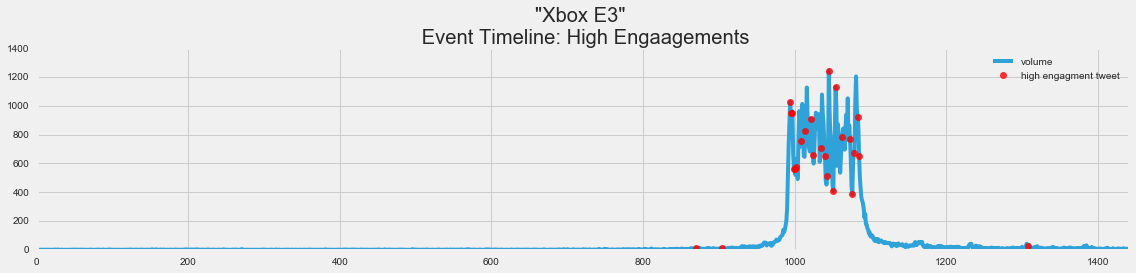

In [381]:
plt.title('"%s" \n Event Timeline: High Engaagements' % event_name)
ax = timelinesummary_engagements['volume'].plot(figsize=(16,4))
timelinesummary_engagements[timelinesummary_engagements['rank'] <= k]['volume'].plot(ax=ax, style='ro', alpha=.8, label='high engagment tweet')
plt.legend(loc='best')
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/summary_%s_engagements.png' % event_filename)

In [382]:
#summary_engagements.set_index('created_at').sort_index(ascending=True)

### Subevents

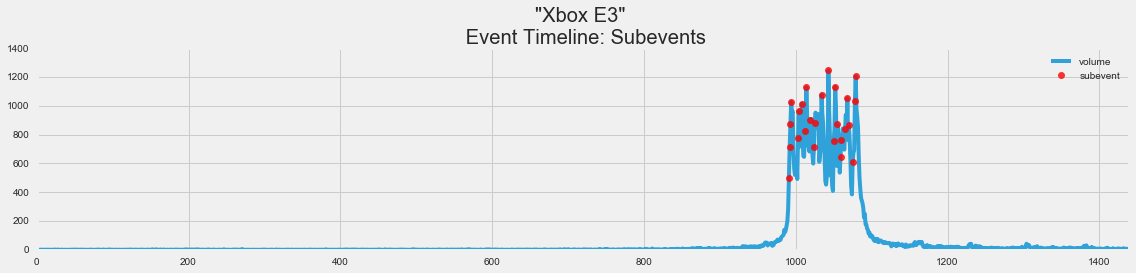

In [383]:
plt.title('"%s" \n Event Timeline: Subevents' % event_name)
ax = timelinesummary_pr_subevents['volume'].plot(figsize=(16,4))
timelinesummary_pr_subevents[timelinesummary_pr_subevents['rank'] <= k]['volume'].plot(ax=ax, style='ro', alpha=.8, label='subevent')
plt.legend(loc='best')
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/summary_%s_subevents.png' % event_filename)

In [384]:
#summary_subevents.set_index('created_at').sort_index(ascending=True)

#### export for evaluation

In [385]:
summary_engagements.to_csv('data/final/summary/foreval_event_%s_summary_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)
pr_summary_subevents.to_csv('data/final/summary/foreval_event_%s_summary_pr_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)
prplus_summary_subevents.to_csv('data/final/summary/foreval_event_%s_summary_prplus_subevents.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)